# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
# !apt update
# !apt install python-opengl xvfb -y
# !pip install -q swig
# !pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4 
# !pip install box2d==2.3.2 box2d-kengz
# !pip freeze > requirements.txt



Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

from IPython import display
import imageio

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from collections import deque, namedtuple
from einops import repeat
from torch.distributions import MultivariateNormal, Normal
from torch.nn.utils import clip_grad_norm_

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [4]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [5]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [6]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [7]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [8]:
initial_state = env.reset()
print(initial_state)

[ 0.00215788  1.4030764   0.21855156 -0.3486134  -0.00249362 -0.0495052
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [9]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [10]:
observation, reward, done, info = env.step(random_action)

In [11]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [12]:
print(reward)

-1.58213605344352


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

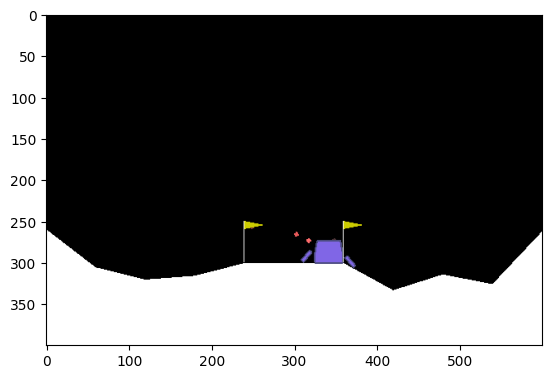

In [13]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Noisy Networks

In [14]:
from abc import ABC

class AbstractNoisyLayer(nn.Module, ABC):
    def __init__(
            self,
            input_features: int,
            output_features: int,
            sigma: float,
    ):
        super().__init__()

        self.sigma = sigma
        self.input_features = input_features
        self.output_features = output_features

        self.mu_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.mu_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.sigma_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))

        self.register_buffer('epsilon_input', torch.FloatTensor(input_features))
        self.register_buffer('epsilon_output', torch.FloatTensor(output_features))

    def forward(
            self,
            x: torch.Tensor,
            sample_noise: bool = True
    ) -> torch.Tensor:
        if not self.training:
            return nn.functional.linear(x, weight=self.mu_weight, bias=self.mu_bias)

        if sample_noise:
            self.sample_noise()

        return nn.functional.linear(x, weight=self.weight, bias=self.bias)

    @property
    def weight(self) -> torch.Tensor:
        raise NotImplementedError

    @property
    def bias(self) -> torch.Tensor:
        raise NotImplementedError

    def sample_noise(self) -> None:
        raise NotImplementedError

    def parameter_initialization(self) -> None:
        raise NotImplementedError

    def get_noise_tensor(self, features: int) -> torch.Tensor:
        noise = torch.FloatTensor(features).uniform_(-self.bound, self.bound).to(self.mu_bias.device)
        return torch.sign(noise) * torch.sqrt(torch.abs(noise))


class IndependentNoisyLayer(AbstractNoisyLayer):
    def __init__(
            self,
            input_features: int,
            output_features: int,
            sigma: float = 0.017,
    ):
        super(AbstractNoisyLayer).__init__(
            input_features=input_features,
            output_features=output_features,
            sigma=sigma
        )

        self.bound = (3 / input_features) ** 0.5
        self.parameter_initialization()
        self.sample_noise()

    @property
    def weight(self) -> torch.Tensor:
        return self.sigma_weight * self.epsilon_weight + self.mu_weight

    @property
    def bias(self) -> torch.Tensor:
        return self.sigma_bias * self.epsilon_bias + self.mu_bias

    def sample_noise(self) -> None:
        self.epsilon_bias = self.get_noise_tensor((self.output_features,))
        self.epsilon_weight = self.get_noise_tensor((self.output_features, self.input_features))

    def parameter_initialization(self) -> None:
        self.sigma_bias.data.fill_(self.sigma)
        self.sigma_weight.data.fill_(self.sigma)
        self.mu_bias.data.uniform_(-self.bound, self.bound)
        self.mu_weight.data.uniform_(-self.bound, self.bound)


class FactorisedNoisyLayer(AbstractNoisyLayer):
    def __init__(
            self,
            input_features: int,
            output_features: int,
            sigma: float = 0.5,
    ):
        super().__init__(
            input_features=input_features,
            output_features=output_features,
            sigma=sigma
        )

        # self.input_features = input_features
        # self.output_features = output_features
        # self.sigma = sigma

        self.bound = input_features**(-0.5)
        self.parameter_initialization()
        self.sample_noise()

    @property
    def weight(self) -> torch.Tensor:
        return self.sigma_weight * torch.ger(self.epsilon_output, self.epsilon_input) + self.mu_weight

    @property
    def bias(self) -> torch.Tensor:
        return self.sigma_bias * self.epsilon_output + self.mu_bias

    def sample_noise(self) -> None:
        self.epsilon_input = self.get_noise_tensor(self.input_features)
        self.epsilon_output = self.get_noise_tensor(self.output_features)

    def parameter_initialization(self) -> None:
        self.mu_bias.data.uniform_(-self.bound, self.bound)
        self.sigma_bias.data.fill_(self.sigma * self.bound)
        self.mu_weight.data.uniform_(-self.bound, self.bound)
        self.sigma_weight.data.fill_(self.sigma * self.bound)

In [43]:
from datetime import datetime
BUFFER_SIZE = 5000000000  # replay buffer size
BATCH_SIZE = 32         # minibatch size
EPOCH = 4000
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 10        # how often to update the network
DUELING = True
PARAM_NOISE = True

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [44]:
# class PolicyGradientNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(8, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 4)
#     def forward(self, state):
#         hid = torch.tanh(self.fc1(state))
#         hid = torch.tanh(hid)
#         return F.softmax(self.fc3(hid), dim=-1)
    
class DQN(nn.Module):
    """Actor (Policy) Model"""
    def __init__(self, b_dueling=False, b_param_noise=False, sigma=0.5):
        super().__init__()
        self.b_dueling = b_dueling
        self.b_param_noise = b_param_noise
        self.input_dim = 8
        self.latent_dim = 16
        self.output_dim = 4
        self.pre_net = nn.Sequential(
            nn.Linear(self.input_dim, self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim,self.latent_dim),
            nn.ReLU(),
        )
        self.noisy_pre_net = nn.Sequential(
            FactorisedNoisyLayer(self.input_dim, self.latent_dim, sigma=sigma),
            nn.ReLU(),
            FactorisedNoisyLayer(self.latent_dim, self.latent_dim, sigma=sigma),
            nn.ReLU(),
        )

        self.netA = nn.Sequential(
            nn.Linear(self.latent_dim, self.output_dim),
        )
        self.netV = nn.Sequential(
            nn.Linear(self.latent_dim, int(self.latent_dim/2)),
            nn.ReLU(),
            nn.Linear(int(self.latent_dim/2),1),
            # nn.Linear(self.latent_dim, 1),
            nn.ReLU(),
        )
        self.noisy_netA = nn.Sequential(
            FactorisedNoisyLayer(self.latent_dim, self.output_dim, sigma=sigma),
        )
        self.noisy_netV = nn.Sequential(
            FactorisedNoisyLayer(self.latent_dim, int(self.latent_dim/2), sigma=sigma),
            nn.ReLU(),
            FactorisedNoisyLayer(int(self.latent_dim/2), 1, sigma=sigma),
            # FactorisedNoisyLayer(self.latent_dim, 1, sigma=sigma),
            nn.ReLU(),
        )
    
    def forward(self, state):
        x = state
        if self.b_param_noise:
            x = self.noisy_pre_net(x)
            outA = self.noisy_netA(x)
            outA = outA.reshape(-1,self.output_dim)
            outV = 0
            if self.b_dueling:
                outV = self.noisy_netV(x)
                return (outA - torch.mean(outA)) + outV, outA, outV
            else:
                return outA, outA, outV
        else:
            x = self.pre_net(x)
            outA = self.netA(x)
            outA = outA.reshape(-1,self.output_dim)
            outV = 0
            if self.b_dueling:
                outV = self.netV(x)
                return (outA - torch.mean(outA)) + outV, outA, outV
            else:
                return outA, outA, outV

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [45]:
from torch.optim.lr_scheduler import StepLR
# class PolicyGradientAgent():
#     def __init__(self, network):
#         self.network = network
#         self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)
        
#     def forward(self, state):
#         return self.network(state)
#     def learn(self, log_probs, rewards):
#         loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
        
#     def sample(self, state):
#         action_prob = self.network(torch.FloatTensor(state))
#         action_dist = Categorical(action_prob)
#         action = action_dist.sample()
#         log_prob = action_dist.log_prob(action)
#         return action.item(), log_prob

class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = DQN(DUELING).to(device)
        self.qnetwork_target = DQN(DUELING).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next, val_A, val_V = self.qnetwork_target(next_states)
        q_targets_next = q_targets_next.detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected, val_A, val_V = self.qnetwork_local(states)
        q_expected = q_expected.gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                    
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)

    def sample_action(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        # Double DQN
        with torch.no_grad():
            action_values, val_A, val_V = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if PARAM_NOISE:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Epsilon-greedy action selection
            if random.random() > eps: # choose action with best value
                return np.argmax(action_values.cpu().data.numpy())
            else: # random exploration
                return random.choice(np.arange(self.action_size))

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, MODEL_PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.qnetwork_local.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, MODEL_PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.qnetwork_local.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

Define Replay Buffer

In [46]:
class ReplayBuffer():
    def __init__(self, buffer_size=5000):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        self.memory = deque([], maxlen=buffer_size)
    
    class experience():
        def __init__(self, state, action, reward, next_state, done):
            self.state = state
            self.action = action
            self.reward = reward
            self.next_state = next_state
            self.done = done


    def push(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, BATCH):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, BATCH)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Lastly, build a network and agent to start training.

In [47]:
# network = PolicyGradientNetwork()
# agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [48]:
def test(agent, action_list_path):
    fix(env, seed)
    agent.qnetwork_local.eval()  # set the network into evaluation mode
    agent.qnetwork_target.eval()  # set the network into evaluation mode
    NUM_OF_TEST = 5 # Do not revise this !!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.sample_action(state)
            actions.append(action)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        test_total_reward.append(total_reward)
        action_list.append(actions) # save the result of testing 
    #print("  test-total-reward: ", test_total_reward)
    np.save(action_list_path, np.array(action_list)) 
    return np.mean(test_total_reward)

In [49]:
avg_total_rewards, avg_final_rewards = [], []
total_rewards, final_rewards = [], []

def train(agent, n_episode=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, work_dir="./", save_every=200):
    """Deep Q-Learning
    Params
    ======
        n_epoch (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection (similar to 'T' in SA)
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    ckpt_dir = "./{}/models/".format(work_dir)
    fig_dir = "./{}/figs/".format(work_dir)
    actions_dir = "./{}/actions/".format(work_dir)
    best_dir = "./{}/best/".format(work_dir)
    !mkdir -p "{ckpt_dir}" "{fig_dir}" "{best_dir}" "{actions_dir}"

    total_rewards_window = deque(maxlen=1000)  # last 100 scores
    best_reward = -9999
    best_score = -9999 # tested reward
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episode+1):
        state = env.reset()
        total_reward = 0
        final_reward = -1
        img_list = []
        action_list = []
        step_count = 0
        for t in range(max_t):
            action = agent.sample_action(state, eps)
            action_list.append(action)
            next_state, reward, done, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if i_episode % save_every == 0 or (i_episode%10==0 and i_episode<save_every) or i_episode==1:
                img_list.append(Image.fromarray(env.render(mode='rgb_array'), 'RGB'))
            if done:
                step_count = t
                final_reward = reward
                final_rewards.append(final_reward)
                break 
            if t == max_t-1:
                step_count = t
                total_reward += -100
                final_reward = -100+reward
                final_rewards.append(final_reward)
                break 
        total_rewards_window.append(total_reward)              # save most recent score
        total_rewards.append(total_reward)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 100 == 0 or i_episode < 10:
            print('\rEpisode {}\tAction length: {}, Total reward: {:.2f}, Average reward: {:.2f}, Final reward: {:.2f}'.format(i_episode, step_count, total_reward, np.mean(total_rewards_window), final_reward))
        else: print(".", end="")
        if i_episode % save_every == 0 or i_episode==1:
            chechpoint_pth = ckpt_dir+ f"Agent_Dict-{i_episode}.ckpt"
            #print(f"\rsave model as {chechpoint_pth}.")
            chechpoint_pth = ckpt_dir+ f"Agent_Dict-{i_episode}.ckpt"
            agent.save(chechpoint_pth)
            np.save(ckpt_dir+f"Action_List-{i_episode}.npy" ,np.array(action_list)) 
            gif_pth = fig_dir + f"layout-{i_episode}.gif"
            imageio.mimsave(gif_pth, img_list, 'GIF', duration=0.002)
            img_list[0].save(gif_pth, save_all=True, append_images=img_list)
            # test
            action_list_path = actions_dir+f"Action_List-{i_episode}.npy"
            test(agent, action_list_path)
        
        if total_reward >= best_reward and final_reward == 100:
            print('\rEpisode {}\tAction length: {}, Total reward: {:.2f}, Average reward: {:.2f}, Final reward: {:.2f} <-- good'.format(i_episode, step_count, total_reward, np.mean(total_rewards_window), final_reward))
            # test
            action_list_path = actions_dir+f"Action_List-{i_episode}.npy"
            test_reward = test(agent, action_list_path)
            if test_reward > best_reward:
                best_reward = test_reward
                !rm -f "{best_dir}*.ckpt"
                agent.save(best_dir+"Agent_Dict.ckpt")
                best_i_txt = best_dir+"best-i.txt"
                !echo "{i_episode}" best_reward="{best_reward}" > "{best_i_txt}"
                np.save(best_dir+"Action_List.npy" ,np.array(action_list))
                print('\rEpisode {}\t Avg test reward: {:.2f} <-- best'.format(i_episode, test_reward))
                cp_cmd = f"cp {action_list_path} {best_dir}Action_List-test.npy"
                os.system(cp_cmd)
        elif final_reward == 100:
            print('\rEpisode {}\tAction length: {}, Total reward: {:.2f}, Average reward: {:.2f}, Final reward: {:.2f} <-- success'.format(i_episode, step_count, total_reward, np.mean(total_rewards_window), final_reward))

        # 紀錄訓練過程 
        avg_total_reward, avg_final_reward = 0, 0
        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
    print((f"avgTotal: {avg_total_reward: 4.1f}, avgFinalReward: {avg_final_reward: 4.1f}, bestReward: {best_reward}"))

    return total_rewards, final_rewards, best_reward

In [50]:
work_name = "lunar"
if DUELING: work_name += "-Duel"
if PARAM_NOISE: work_name += "-noisy"
work_name += "-LR" + str(LR) + "-GAMMA" + str(GAMMA)

start_run_time = datetime.now().strftime("%m%d-%H%M")
work_dir = start_run_time + "_" + work_name
print(work_dir)

import time
start = time.time()

agent = Agent(state_size=8, action_size=4)
agent.qnetwork_local.train()  # 訓練前，先確保 network 處在 training 模式
total_rewards, final_rewards, best_reward = train(agent, n_episode=EPOCH, max_t=9999, work_dir=work_dir, save_every=50)
end = time.time()

print(f"\nTotal time is {end-start} sec")
print(f"Best Reward is {best_reward}")

## Write training process
with open(f'{work_dir}/rewards.txt', 'a') as fp:
    for i in range(EPOCH):
        fp.write("%s " % total_rewards[i])
    fp.write("\n")
with open(f'{work_dir}/costs.txt', 'a') as fp:
    for i in range(EPOCH):
        fp.write("%s " % final_rewards[i])
    fp.write("\n")

0616-1609_lunar-Duel-noisy-LR0.001-GAMMA0.99
Episode 1	Action length: 93, Total reward: -712.89, Average reward: -712.89, Final reward: -100.00


/home/frankchiang/local/anaconda3/envs/ml2023_hw12/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Episode 2	Action length: 59, Total reward: -568.59, Average reward: -640.74, Final reward: -100.00
Episode 3	Action length: 63, Total reward: -503.81, Average reward: -595.09, Final reward: -100.00
Episode 4	Action length: 78, Total reward: -724.44, Average reward: -627.43, Final reward: -100.00
Episode 5	Action length: 66, Total reward: -134.95, Average reward: -528.94, Final reward: -100.00
Episode 6	Action length: 74, Total reward: -743.17, Average reward: -564.64, Final reward: -100.00
Episode 7	Action length: 51, Total reward: -445.37, Average reward: -547.60, Final reward: -100.00
Episode 8	Action length: 78, Total reward: -710.11, Average reward: -567.92, Final reward: -100.00
Episode 9	Action length: 77, Total reward: -398.86, Average reward: -549.13, Final reward: -100.00
Episode 100	Action length: 158, Total reward: -155.87, Average reward: -170.76, Final reward: -100.00
Episode 200	Action length: 354, Total reward: -97.18, Average reward: -168.24, Final reward: -100.00
Episo

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


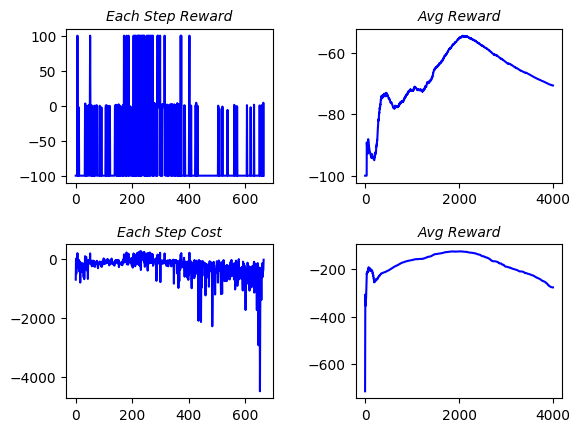

In [23]:
import math

resol=6
colors = ['blue', 'red', 'orange', 'green', 'purple']
fig, axarr = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
with open(f'{work_dir}/costs.txt', 'r') as fp: # costs
    lines=fp.readlines()
    lines=[list(map(float,line.split())) for line in lines]
    avgs=[]
    for i in range(len(lines)):
        EPOCH = len(lines[i])
        avg=[]
        for j in range(len(lines[i])):
            avg.append(sum(lines[i][0:(j+1)]) / (j+1))
        avgs.append(avg)
    for i in range(len(lines)):
        axarr[0][0].plot(range(math.ceil(EPOCH/resol)), lines[i][0::resol], color=colors[i])
        axarr[0][0].set_title('Each Step Reward', fontstyle='italic', fontsize='medium')
        axarr[0][1].plot(range(EPOCH), avgs[i], color=colors[i])
        axarr[0][1].set_title('Avg Reward', fontstyle='italic', fontsize='medium')
fp.close()
with open(f'{work_dir}/rewards.txt', 'r') as fp2: # rewards
    lines=fp2.readlines()
    lines=[list(map(float,line.split())) for line in lines]
    avgs=[]
    for i in range(len(lines)):
        EPOCH = len(lines[i])
        avg=[]
        for j in range(len(lines[i])):
            avg.append(sum(lines[i][0:(j+1)]) / (j+1))
        avgs.append(avg)
    for i in range(len(lines)):
        axarr[1][0].plot(range(math.ceil(EPOCH/resol)), lines[i][0::resol], color=colors[i])
        axarr[1][0].set_title('Each Step Cost', fontstyle='italic', fontsize='medium')
        axarr[1][1].plot(range(EPOCH), avgs[i], color=colors[i])
        axarr[1][1].set_title('Avg Reward', fontstyle='italic', fontsize='medium')
fp2.close()
plt.show()

## Testing
The testing result will be the average reward of 5 testing

170.67359761626523


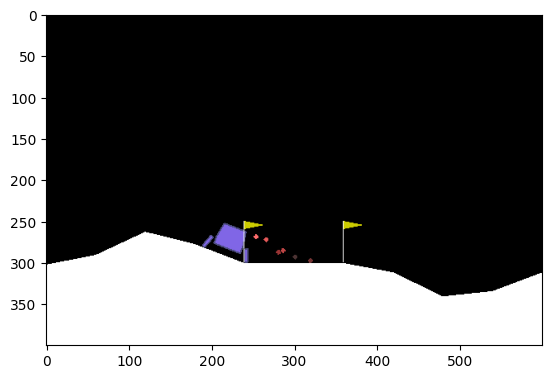

In [24]:
best_dir = "./{}/best/".format(work_dir)
print(f"best_dir: {best_dir}")
agent.load(best_dir+'Agent_Dict.ckpt')

fix(env, seed)
agent.qnetwork_local.eval()  # set the network into evaluation mode
agent.qnetwork_target.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))
  total_reward = 0
  done = False
  while not done:
    action = agent.sample_action(state)
    actions.append(action)
    state, reward, done, _ = env.step(action)
    total_reward += reward
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True) 
  print(total_reward)
  test_total_reward.append(total_reward)
  action_list.append(actions) # save the result of testing 

In [25]:
print(np.mean(test_total_reward))

136.9959313438328


Action list

In [52]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

for actions in action_list:
    print("Action shape looks like ", np.shape(actions))

Action list looks like  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,

/home/frankchiang/local/anaconda3/envs/ml2023_hw12/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Analysis of actions taken by agent

In [53]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{0: 940, 2: 1341, 1: 276, 3: 211}


Saving the result of Model Testing


In [ ]:
# PATH = "Action_List.npy" # Can be modified into the name or path you want
# np.save(PATH ,np.array(action_list)) 

### This is the file you need to submit !!!
Download the testing result to your device



In [54]:
PATH=best_dir+"Action_List-test.npy"
# from google.colab import files
# files.download(PATH)

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

In [61]:
# PATH=best_dir+"Action_List-test.npy"
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.qnetwork_local.eval()  # set network to evaluation mode
agent.qnetwork_target.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for i, actions in enumerate(action_list):
  state = env.reset()
  #img = plt.imshow(env.render(mode='rgb_array'))
  img_list = []
  total_reward = 0
  done = False
  for action in actions:
      state, reward, done, _ = env.step(action)
      total_reward += reward
      img_list.append(Image.fromarray(env.render(mode='rgb_array'), 'RGB'))
      if done:
        break
  gif_pth = best_dir + f"layout-{i}.gif"
  imageio.mimsave(gif_pth, img_list, 'GIF', duration=1000)
  img_list[0].save(gif_pth, save_all=True, append_images=img_list)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

Your reward is : 85.80
Your reward is : 194.13
Your reward is : 249.49
Your reward is : -15.11
Your reward is : 170.67


In [57]:
print(best_dir)

./0616-0220_lunar-Duel-noisy/best/


# Your score

In [58]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 136.99


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
